In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import shutil

In [119]:
from pointer_utils import *

In [4]:
frame,classIds,confidences,boxes = preprocess('20180119153156.jpg')

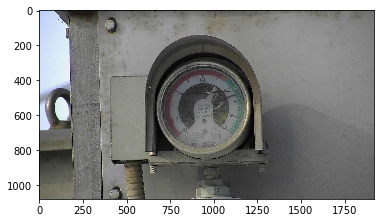

In [5]:
plt.imshow(frame)

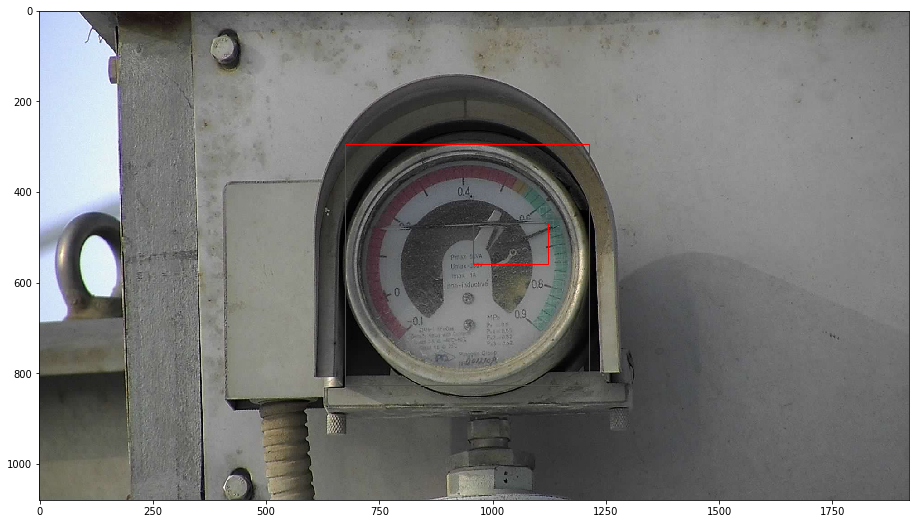

In [7]:
fig = plt.figure(figsize=(16,9))
show_detection2(frame, boxes)

这个属于不太精确的结果，我们看看用OpenCV直接连一条线的结果是什么。

In [11]:
classIds,boxes

([0, 1], [[674, 294, 540, 533], [957, 469, 166, 91]])

In [25]:
frame_line = frame.copy()

In [26]:
pt = boxes[1]

In [27]:
cv.line(frame_line, (pt[0],pt[1]+pt[3]), (pt[0]+pt[2], pt[1]), (255, 0, 255), 3, 8);

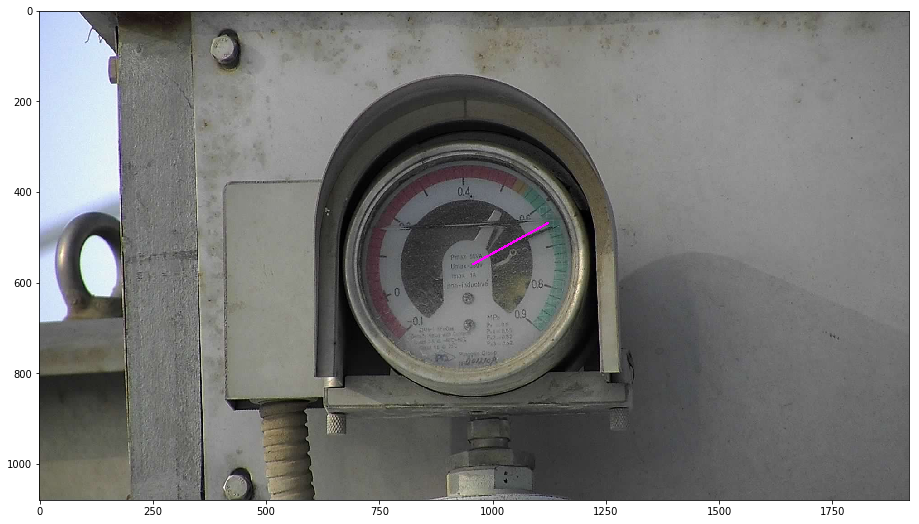

In [28]:
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

当然也有很多检测地相当准地，虽然它是不是其实在检测表上一个固定的区域是一个难以回答的问题。

In [29]:
frame,classIds,confidences,boxes = preprocess('20180326110600.jpg')

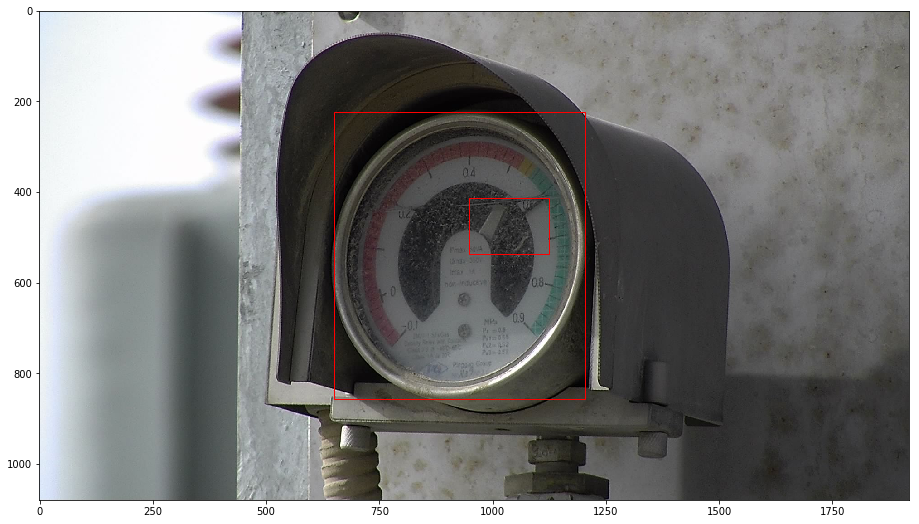

In [30]:
fig = plt.figure(figsize=(16,9))
show_detection2(frame, boxes)

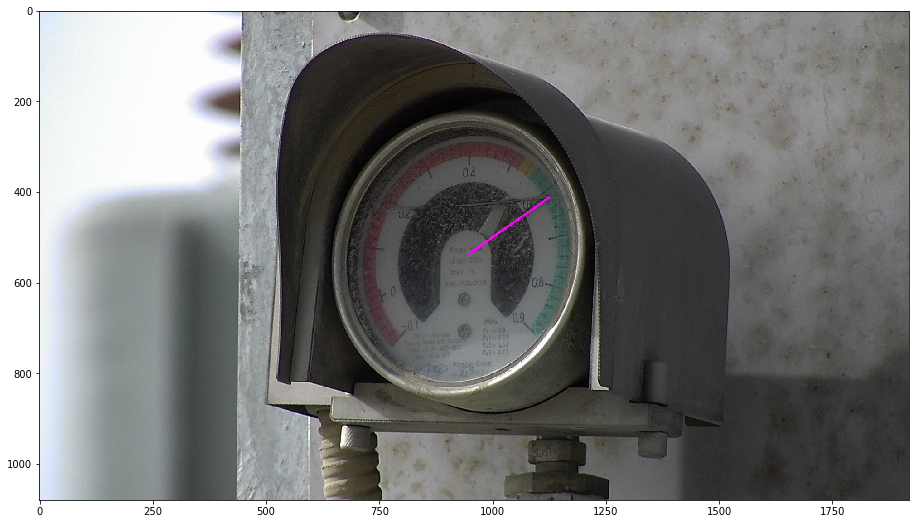

In [31]:
frame_line = frame.copy()

pt = boxes[1]
cv.line(frame_line, (pt[0],pt[1]+pt[3]), (pt[0]+pt[2], pt[1]), (255, 0, 255), 3, 8);

plt.figure(figsize=(16,9))
plt.imshow(frame_line)

在解决较准问题前我们可以做个quick fix for angle value。

In [35]:
tail = (pt[0],pt[1]+pt[3])
head = (pt[0]+pt[2],pt[1])

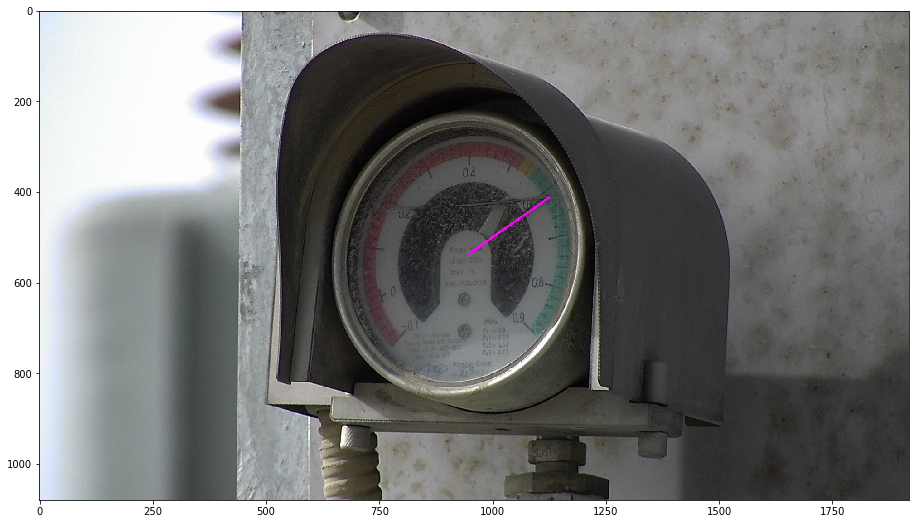

In [36]:
frame_line = frame.copy()

pt = boxes[1]
cv.line(frame_line, tail, head, (255, 0, 255), 3, 8);

plt.figure(figsize=(16,9))
plt.imshow(frame_line)

In [38]:
angle = np.arctan((head[1] - tail[1])/(head[0]-tail[0])) # 注意y轴向下
angle

-0.6111050394279125

In [45]:
# (-\pi/2,0) -> (0.6,0.74)
point = (angle/(np.pi/2)+1)*(0.74-0.6)+0.6
point

0.6855341828469409

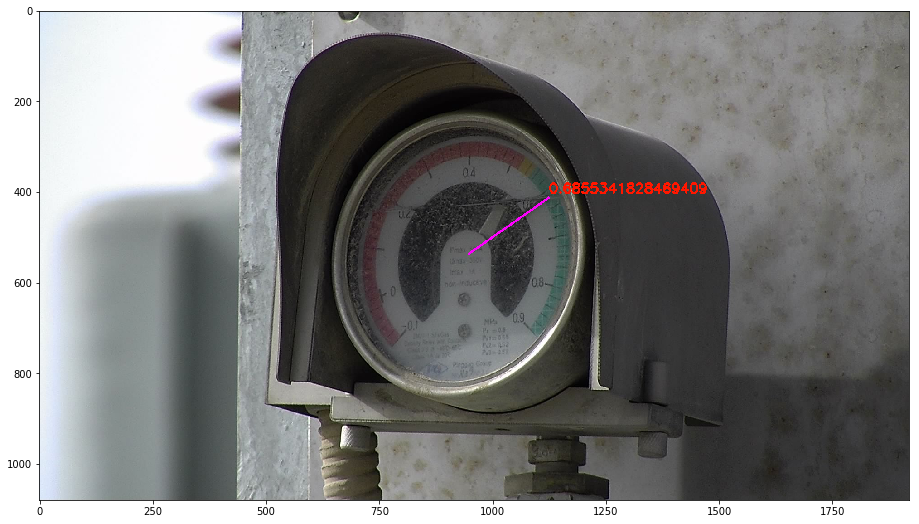

In [51]:
frame_line = frame.copy()

pt = boxes[1]
angle = np.arctan((head[1] - tail[1])/(head[0]-tail[0]))
point = (angle/(np.pi/2)+1)*(0.74-0.6)+0.6

cv.line(frame_line, tail, head, (255, 0, 255), 3, 8);
cv.putText(frame_line, str(point), (head[0],head[1]-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)

plt.figure(figsize=(16,9))
plt.imshow(frame_line)

不过这套操作都假设了指针总指着右上角那块区域，真没问题吗。。毕竟这种算法本来就是为了发现异常（转到0什么的）用的吧。。

不过目前够用就行，我们先讨论怎么微调上面那种情况，先看看不需要微调时的特征情况。指针在右上角一小块区域其实还是比较突兀的，
我们可以观察它与框的上边或下边的交点，或者说边界点附近比较特别地那些点，选择为校正后的边界点，注意对抗噪声，而且微调允许范围不能太大，
总会有难以预测的情况出现。

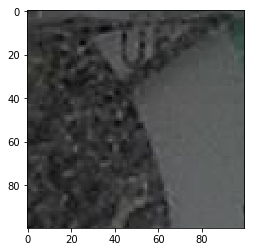

In [60]:
plt.imshow(frame[head[1]:head[1]+100,head[0]-100:head[0]])

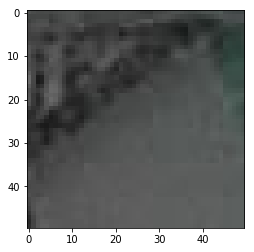

In [61]:
plt.imshow(frame[head[1]:head[1]+50,head[0]-50:head[0]])

这要不是看过上面那张图谁知道这是个指针。。

In [62]:
cv.cvtColor?

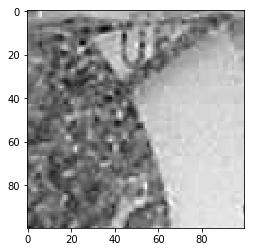

In [64]:
frame_gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
plt.imshow(frame_gray[head[1]:head[1]+100,head[0]-100:head[0]], cmap='gray')

In [65]:
crop_gray = frame_gray[head[1]:head[1]+100,head[0]-100:head[0]]

转成灰度图倒是清楚了一点，不过这个噪声厉害了。既然这里实际上还是有“边缘”，首先还是考虑用边缘检测特征图的结果。噪声先用高斯滤波器什么的
对付一下。

In [66]:
sobelx8u = cv.Sobel(crop_gray, cv.CV_8U, 1, 0, ksize=5)
sobely8u = cv.Sobel(crop_gray, cv.CV_8U, 0, 1, ksize=5)

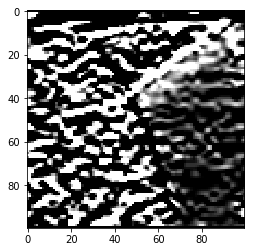

In [67]:
plt.imshow(sobely8u, cmap='gray')

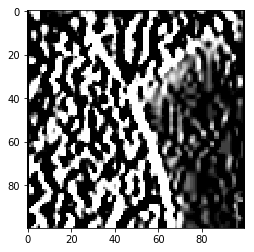

In [68]:
plt.imshow(sobelx8u, cmap='gray')

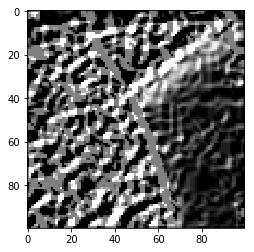

In [70]:
plt.imshow(np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float)), cmap='gray')

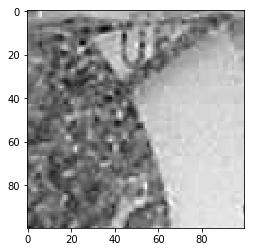

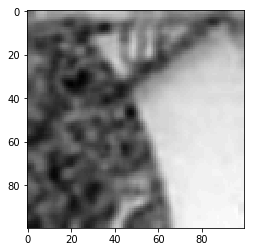

In [85]:
crop_blured = crop_gray.copy()
crop_blured = cv.GaussianBlur(crop_gray, (5,5), 10.0) # 这居然不是个inplace操作

plt.imshow(crop_gray, cmap='gray') 
plt.show()
plt.imshow(crop_blured, cmap='gray')
plt.show()

In [86]:
sobelx8u = cv.Sobel(crop_blured, cv.CV_8U, 1, 0, ksize=5)
sobely8u = cv.Sobel(crop_blured, cv.CV_8U, 0, 1, ksize=5)

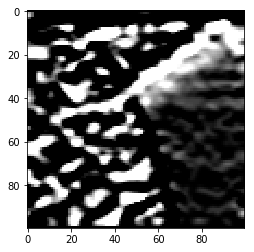

In [87]:
plt.imshow(sobely8u, cmap='gray')

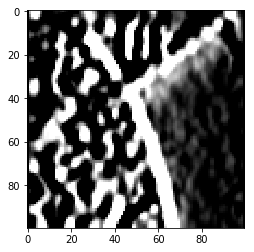

In [88]:
plt.imshow(sobelx8u, cmap='gray')

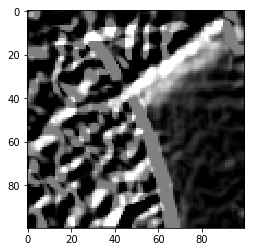

In [89]:
plt.imshow(np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float)), cmap='gray')

In [90]:
frame,classIds,confidences,boxes = preprocess('20180119153156.jpg')

In [91]:
pt = boxes[1]


In [92]:
tail = (pt[0],pt[1]+pt[3])
head = (pt[0]+pt[2],pt[1])

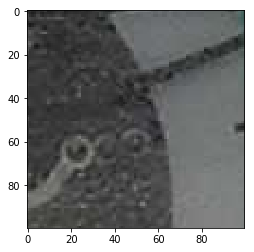

In [93]:
plt.imshow(frame[head[1]:head[1]+100,head[0]-100:head[0]])

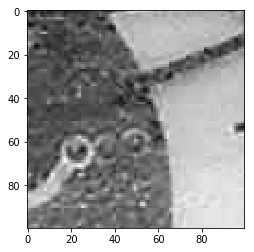

In [94]:
frame_gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
plt.imshow(frame_gray[head[1]:head[1]+100,head[0]-100:head[0]], cmap='gray')

In [96]:
crop_gray = frame_gray[head[1]:head[1]+100,head[0]-100:head[0]]
sobelx8u = cv.Sobel(crop_gray, cv.CV_8U, 1, 0, ksize=5)
sobely8u = cv.Sobel(crop_gray, cv.CV_8U, 0, 1, ksize=5)

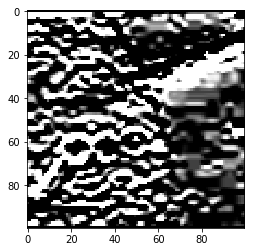

In [97]:
plt.imshow(sobely8u, cmap='gray')

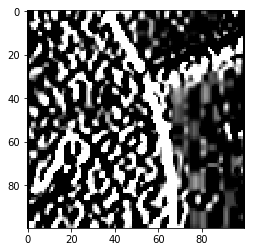

In [98]:
plt.imshow(sobelx8u, cmap='gray')

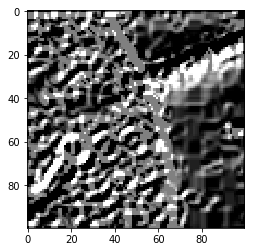

In [99]:
plt.imshow(np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float)), cmap='gray')

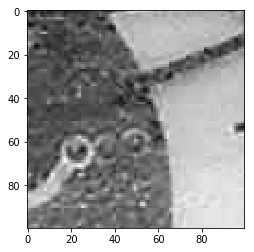

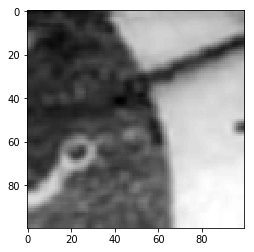

In [100]:
crop_blured = cv.GaussianBlur(crop_gray, (5,5), 10.0) # 这居然不是个inplace操作

plt.imshow(crop_gray, cmap='gray') 
plt.show()
plt.imshow(crop_blured, cmap='gray')
plt.show()

In [101]:
sobelx8u = cv.Sobel(crop_blured, cv.CV_8U, 1, 0, ksize=5)
sobely8u = cv.Sobel(crop_blured, cv.CV_8U, 0, 1, ksize=5)

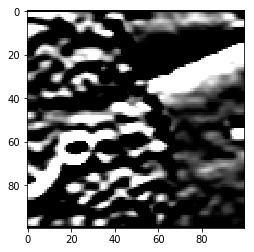

In [102]:
plt.imshow(sobely8u, cmap='gray')

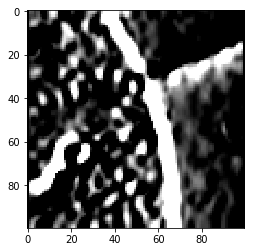

In [103]:
plt.imshow(sobelx8u, cmap='gray')

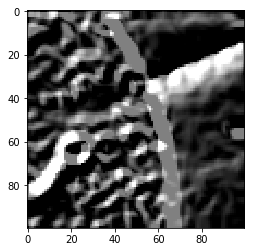

In [104]:
plt.imshow(np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float)), cmap='gray')

目前思路是在右上角的一个小邻域（不止边缘上的点）上搜索取得最高灰度梯度者，将其作为较准对象，搜索范围可以选择与表的大小成某一比例的值。

In [106]:
boxes[0][2],boxes[0][3]

(540, 533)

看起来1/10是个不错的值(相当于上图中只检测一半区域)，太大可能噪声造成检测反而不稳健。我们在一个矩形或三角形里检测。

In [108]:
mag = np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float))

In [109]:
mag.argmax()

111

In [115]:
minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(mag[:50,-50:])
maxLoc

(47, 16)

In [116]:
maxLoc[0],maxLoc[1]+mag.shape[1]-50

(47, 66)

In [117]:
mag.shape

(100, 100)

In [122]:
boxes[0][0] + boxes[0][2]/2,boxes[0][1]+boxes[0][3]/2

(944.0, 560.5)

In [124]:
boxes[1][:2]

[957, 469]

In [218]:
def parse_pointer(frame, dial_box, pointer_box, alpha=0.5, scale_ratio=10):
    '''
    考虑两种较准，head校准，即在网络输出的pointer位置附近找边缘响应值最大者。
    tail较准，将网络预测的tail与dial的中心平均得，这个较准到底用不用看情况。
    '''
    pt = pointer_box
    tail = (pt[0],pt[1]+pt[3])
    head = (pt[0]+pt[2],pt[1])
    
    scale_x = dial_box[2] // scale_ratio
    scale_y = dial_box[3] // scale_ratio
    
    frame_gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    crop_gray = frame_gray[head[1]:head[1]+scale_y,head[0]-scale_x:head[0]]
    
    crop_blured = cv.GaussianBlur(crop_gray, (5,5), 10.0)
    sobelx8u = cv.Sobel(crop_blured, cv.CV_8U, 1, 0, ksize=5)
    sobely8u = cv.Sobel(crop_blured, cv.CV_8U, 0, 1, ksize=5)
    mag = np.abs(sobely8u.astype(float)) + np.abs(sobelx8u.astype(float))
    
    minVal, maxVal, minLoc, maxLoc = cv.minMaxLoc(mag)
    
    head_new = (head[0]-scale_x+maxLoc[0], head[1]+maxLoc[1])
    
    dcx = dial_box[0]+dial_box[2]//2
    dcy = dial_box[1]+dial_box[3]//2
    tail_new = (int(tail[0]*(1-alpha)+dcx*alpha), int(tail[1]*(1-alpha)+dcy*alpha))
    
    return tail,head,tail_new,head_new

In [219]:
tail,head,tail_new,head_new

((957, 560), (1123, 469), (950, 560), (1120, 485))

In [186]:

dial_box = boxes[0]
pointer_box = boxes[1]

tail,head,tail_new,head_new = parse_pointer(frame, dial_box, pointer_box, alpha=0.0)

In [187]:
frame_line = frame.copy()
cv.line(frame_line, tail, head, (255, 0, 255), 3, 8);
cv.line(frame_line, tail_new, head_new, (0, 255, 0), 3, 8);

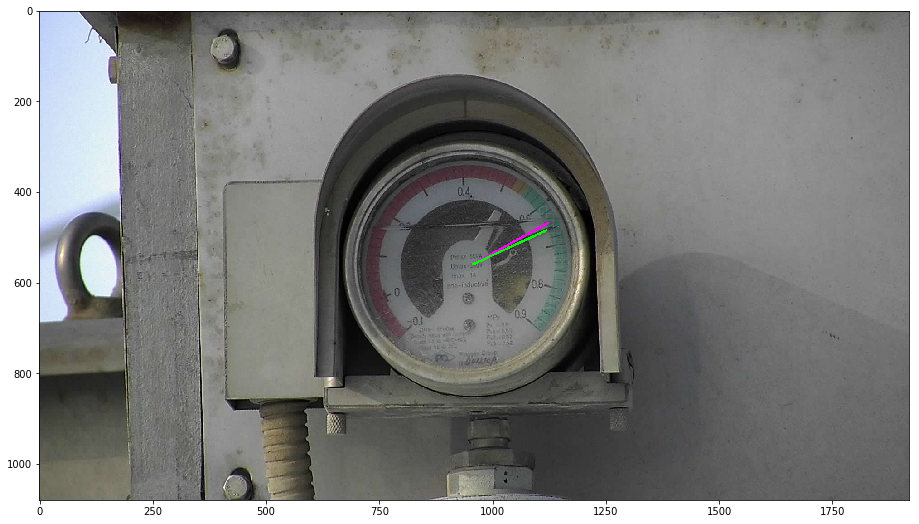

In [188]:
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

In [189]:
tail,head,tail_new,head_new = parse_pointer(frame, dial_box, pointer_box, alpha=0.5)

In [190]:
frame_line = frame.copy()
cv.line(frame_line, tail, head, (255, 0, 255), 3, 8);
cv.line(frame_line, tail_new, head_new, (0, 255, 0), 3, 8);

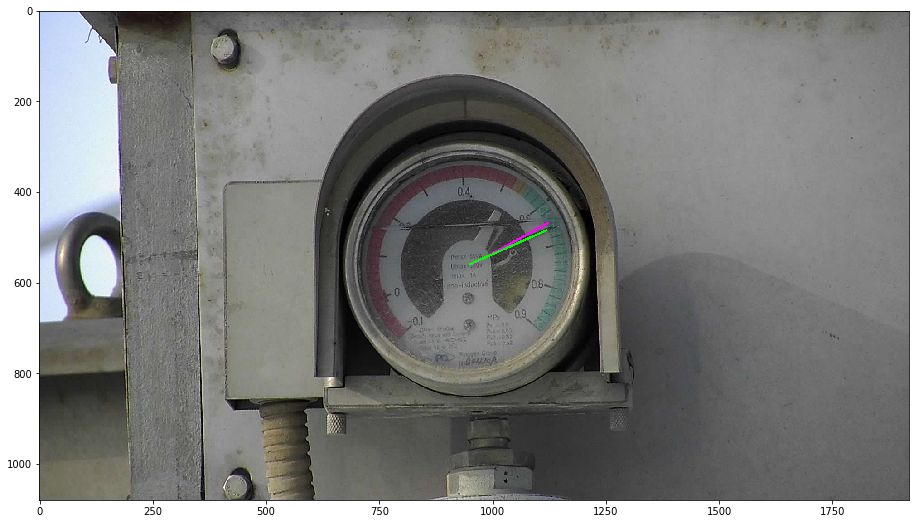

In [191]:
plt.figure(figsize=(16,9))
plt.imshow(frame_line)

In [221]:
def process(frame, classIds, confidences, boxes, alpha=0.0, thickness=3, scale_ratio = 10):
    max_dial_idx, max_pointer_idx = extract_max(classIds, confidences)
    
    if max_dial_idx is None or max_pointer_idx is None:
        return frame.copy()
    
    dial_box = boxes[max_dial_idx]
    pointer_box = boxes[max_pointer_idx]
    
    tail_old, head_old, tail, head = parse_pointer(frame, dial_box, pointer_box, alpha = alpha)
    
    frame_line = frame.copy()
    cv.line(frame_line, tail_old, head_old, (255, 0, 255), thickness, 8);
    cv.line(frame_line, tail, head, (0, 255, 0), thickness, 8);
    
    angle = np.arctan((head[1] - tail[1])/(head[0]-tail[0])) # 注意y轴向下
    point = (angle/(np.pi/2)+1)*(0.74-0.6)+0.6
    
    cv.putText(frame_line, str(point), (head[0],head[1]-10), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 23, 0), 4, 8)
    
    #cv.rectangle()
    return frame_line

In [224]:
def line_callback(frame = None, classIds=None, confidences= None, boxes=None, target_path = None, **kwargs):
    #这里我们阻止batch_detect执行本身的savefig操作，而截获target_path用作我们的输出路径
    frame_line = process(frame, classIds, confidences, boxes, alpha=0.5, thickness=1, scale_ratio=20)
    frame_line = cv.cvtColor(frame_line, cv.COLOR_RGB2BGR)
    cv.imwrite(target_path, frame_line)

In [225]:
batch_detect('data/*.jpg', 'results_line', callback=line_callback, savefig=False)

In [204]:
cv.imwrite?

In [212]:
cv.cvtColor?